Student Details

Name: Fergus Mc Hale

ID: 18203485

# Lab 5: Feature Selection 

This notebook builds on top of Lab 4 by introducing feature selection into the process of selecting the best classifier for a binary classification problem.

The feature selection method applied here is Recursive Feature Elimination (RFE) as demonstrated in the tutorial at https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/.

In this demonstration we use a modified version of the seeds data set (see https://archive.ics.uci.edu/ml/datasets/seeds), which is the same data set used in Lab 4.

## A. Preparation

### Import Python modules

In [22]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np


from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

### Load and prepare the dataset for training and evaluation
Feel free to apply any other pre-processing technique at this point.

In [23]:
et5_df = pd.read_csv("./winequality_red.csv")

In [24]:
et5_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [25]:
numerical_cat = et5_df._get_numeric_data().columns

In [26]:
def plot_feature(feature):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # Add a graph in each part
    sns.boxplot(feature, ax=ax_box)
    sns.distplot(feature, ax=ax_hist)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    plt.show()
    return

In [27]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

In [28]:
def display_field_info(category_type):
    if(len(category_type) > 0):
        for key in category_type:
            print("\n______\t",key,"\t_________")
            print("Total Values = \t",et5_df[key].count(),"\n")
            print(et5_df[key].value_counts())
            iqr_outliners = outliers_iqr(et5_df[key])
            print("Number of Unique Values are ",et5_df[key].nunique())
            print("IQR Outliners = \t",iqr_outliners,"\n")
            print("_________________________________________")
            plot_feature(et5_df[key])
            print("_________________________________________")      


______	 fixed acidity 	_________
Total Values = 	 1599 

7.2     67
7.1     57
7.8     53
7.5     52
7.0     50
7.7     49
6.8     46
7.6     46
8.2     45
7.4     44
7.3     44
8.0     42
7.9     42
8.3     40
6.9     38
6.6     37
8.8     34
8.9     33
9.1     29
6.7     28
8.6     27
9.0     26
8.1     26
8.4     26
9.9     26
6.4     25
8.7     24
10.0    23
9.3     22
10.4    21
        ..
12.7     4
5.8      4
5.3      4
12.6     4
12.4     4
5.1      4
12.2     4
13.0     3
11.0     3
13.2     3
11.8     3
13.3     3
11.7     3
15.5     2
5.7      2
15.6     2
12.9     2
13.7     2
15.0     2
4.9      1
15.9     1
14.3     1
12.1     1
13.8     1
13.5     1
13.4     1
14.0     1
5.5      1
4.6      1
4.7      1
Name: fixed acidity, Length: 96, dtype: int64
Number of Unique Values are  96
IQR Outliners = 	 (array([ 205,  206,  243,  244,  264,  294,  328,  338,  339,  347,  353,
        359,  363,  364,  366,  374,  381,  391,  394,  409,  429,  440,
        442,  446,  470,  47

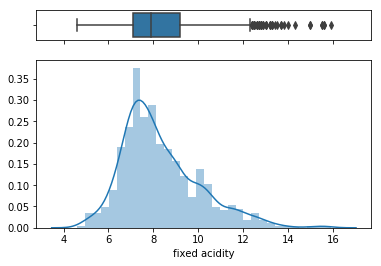

_________________________________________

______	 volatile acidity 	_________
Total Values = 	 1599 

0.600    47
0.500    46
0.430    43
0.590    39
0.360    38
0.580    38
0.400    37
0.490    35
0.380    35
0.390    35
0.560    34
0.520    33
0.410    33
0.460    31
0.540    31
0.420    31
0.340    30
0.310    30
0.530    29
0.630    29
0.570    28
0.610    27
0.640    27
0.660    26
0.370    24
0.480    24
0.510    24
0.620    24
0.670    23
0.440    23
         ..
0.160     2
0.795     2
0.190     2
0.395     2
0.935     2
0.295     1
0.920     1
0.890     1
1.185     1
1.240     1
0.565     1
0.595     1
1.130     1
0.895     1
1.005     1
0.955     1
1.115     1
0.975     1
1.025     1
0.825     1
1.070     1
0.845     1
1.180     1
1.010     1
0.865     1
1.090     1
1.035     1
1.580     1
0.950     1
0.805     1
Name: volatile acidity, Length: 143, dtype: int64
Number of Unique Values are  143
IQR Outliners = 	 (array([  38,   94,  120,  126,  127,  134,  199,  553,  672,  6

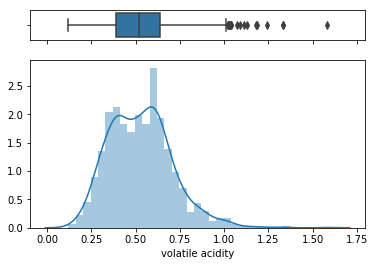

_________________________________________

______	 citric acid 	_________
Total Values = 	 1599 

0.00    132
0.49     68
0.24     51
0.02     50
0.26     38
0.10     35
0.08     33
0.01     33
0.21     33
0.32     32
0.03     30
0.09     30
0.31     30
0.30     30
0.42     29
0.40     29
0.04     29
0.39     28
0.22     27
0.12     27
0.25     27
0.33     25
0.20     25
0.23     25
0.06     24
0.34     24
0.48     23
0.44     23
0.45     22
0.07     22
       ... 
0.38     14
0.53     14
0.51     13
0.54     13
0.35     13
0.55     12
0.68     11
0.63     10
0.57      9
0.64      9
0.16      9
0.58      9
0.60      9
0.59      8
0.56      8
0.65      7
0.74      4
0.69      4
0.76      3
0.73      3
0.67      2
0.61      2
0.70      2
0.71      1
0.79      1
0.75      1
0.78      1
1.00      1
0.62      1
0.72      1
Name: citric acid, Length: 80, dtype: int64
Number of Unique Values are  80
IQR Outliners = 	 (array([151], dtype=int64),) 

_________________________________________


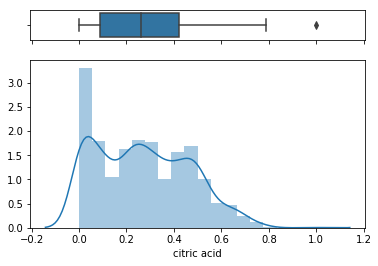

_________________________________________

______	 residual sugar 	_________
Total Values = 	 1599 

2.00     156
2.20     131
1.80     129
2.10     128
1.90     117
2.30     109
2.40      86
2.50      84
2.60      79
1.70      76
1.60      58
2.80      49
2.70      39
1.40      35
1.50      30
3.00      25
2.90      24
3.40      15
3.20      15
4.00      11
3.30      11
5.50       8
4.30       8
3.60       8
1.20       8
3.80       8
3.10       7
4.10       6
5.60       6
3.90       6
        ... 
0.90       2
8.10       2
6.55       2
3.75       1
4.25       1
7.00       1
2.25       1
9.00       1
7.50       1
5.00       1
15.50      1
2.55       1
13.40      1
3.45       1
2.35       1
7.20       1
5.15       1
4.70       1
2.95       1
8.60       1
5.40       1
13.90      1
3.65       1
12.90      1
10.70      1
5.70       1
2.85       1
7.30       1
8.90       1
2.65       1
Name: residual sugar, Length: 91, dtype: int64
Number of Unique Values are  91
IQR Outliners = 	 (array([ 

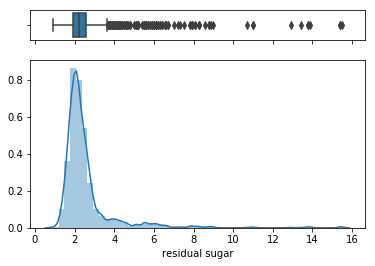

_________________________________________

______	 chlorides 	_________
Total Values = 	 1599 

0.080    66
0.074    55
0.078    51
0.076    51
0.084    49
0.071    47
0.077    47
0.082    46
0.075    45
0.079    43
0.081    40
0.083    35
0.073    35
0.070    35
0.088    32
0.066    32
0.086    31
0.068    30
0.067    27
0.087    25
0.089    25
0.085    25
0.072    24
0.062    24
0.065    23
0.095    23
0.063    22
0.092    22
0.093    21
0.090    21
         ..
0.241     1
0.113     1
0.358     1
0.126     1
0.136     1
0.422     1
0.263     1
0.034     1
0.213     1
0.108     1
0.176     1
0.143     1
0.165     1
0.169     1
0.270     1
0.128     1
0.051     1
0.332     1
0.137     1
0.236     1
0.145     1
0.360     1
0.168     1
0.159     1
0.267     1
0.043     1
0.222     1
0.170     1
0.368     1
0.125     1
Name: chlorides, Length: 153, dtype: int64
Number of Unique Values are  153
IQR Outliners = 	 (array([  14,   15,   17,   19,   38,   42,   81,   83,  106,  109,  120,
    

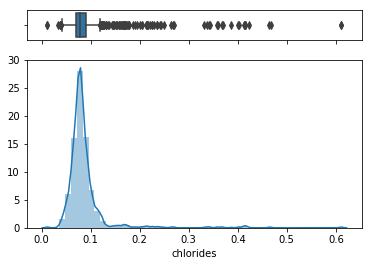

_________________________________________

______	 free sulfur dioxide 	_________
Total Values = 	 1599 

6.0     138
5.0     104
10.0     79
15.0     78
12.0     75
7.0      71
9.0      62
16.0     61
17.0     60
11.0     59
13.0     57
8.0      56
14.0     50
3.0      49
18.0     46
4.0      41
21.0     41
19.0     39
24.0     34
23.0     32
26.0     32
20.0     30
27.0     29
25.0     24
28.0     23
29.0     23
32.0     22
22.0     22
31.0     20
34.0     18
30.0     16
35.0     15
33.0     11
36.0     11
38.0      9
41.0      7
40.0      6
39.0      5
48.0      4
51.0      4
42.0      3
43.0      3
52.0      3
37.0      3
1.0       3
45.0      3
55.0      2
37.5      2
50.0      2
68.0      2
5.5       1
53.0      1
2.0       1
54.0      1
47.0      1
57.0      1
72.0      1
66.0      1
40.5      1
46.0      1
Name: free sulfur dioxide, dtype: int64
Number of Unique Values are  60
IQR Outliners = 	 (array([  14,   15,   57,  396,  400,  497,  522,  584,  634,  678,  925,
        92

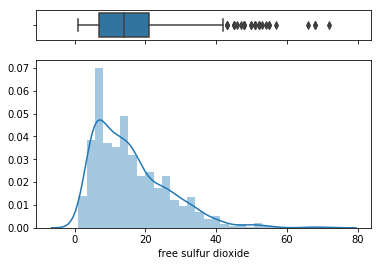

_________________________________________

______	 total sulfur dioxide 	_________
Total Values = 	 1599 

28.0     43
24.0     36
18.0     35
15.0     35
23.0     34
20.0     33
14.0     33
31.0     32
38.0     31
27.0     30
19.0     29
12.0     29
13.0     28
25.0     27
10.0     27
17.0     27
16.0     26
35.0     26
42.0     26
11.0     26
37.0     26
21.0     25
22.0     25
26.0     24
47.0     24
44.0     23
48.0     21
49.0     21
32.0     20
54.0     20
         ..
143.0     2
127.0     2
93.0      2
151.0     2
115.0     2
148.0     2
77.5      2
114.0     2
136.0     2
125.0     2
83.0      2
128.0     2
103.0     2
134.0     2
120.0     2
135.0     2
155.0     1
165.0     1
289.0     1
153.0     1
152.0     1
116.0     1
130.0     1
149.0     1
278.0     1
142.0     1
126.0     1
139.0     1
140.0     1
160.0     1
Name: total sulfur dioxide, Length: 144, dtype: int64
Number of Unique Values are  144
IQR Outliners = 	 (array([  14,   15,   86,   88,   90,   91,   92,  109, 

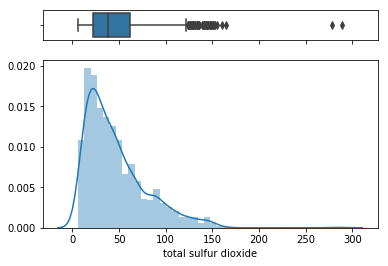

_________________________________________

______	 density 	_________
Total Values = 	 1599 

0.99720    36
0.99760    35
0.99680    35
0.99800    29
0.99620    28
0.99780    26
0.99640    25
0.99700    24
0.99940    24
0.99660    23
0.99820    23
0.99740    22
0.99840    20
0.99880    20
0.99860    19
0.99690    18
0.99730    18
0.99630    15
0.99560    14
0.99550    14
0.99790    14
0.99580    14
0.99590    13
0.99670    13
0.99710    13
0.99600    13
0.99960    12
0.99870    12
0.99650    11
0.99538    11
           ..
1.00289     1
0.99120     1
0.99479     1
0.99473     1
0.99727     1
0.99649     1
0.99385     1
0.99523     1
0.99667     1
0.99410     1
0.99486     1
0.99426     1
0.99582     1
0.99020     1
0.99162     1
0.99332     1
0.99938     1
0.99573     1
0.99459     1
0.99517     1
0.99665     1
0.99521     1
0.99719     1
0.99705     1
0.99722     1
0.99384     1
0.99252     1
0.99823     1
0.99417     1
0.99581     1
Name: density, Length: 436, dtype: int64
Number of U

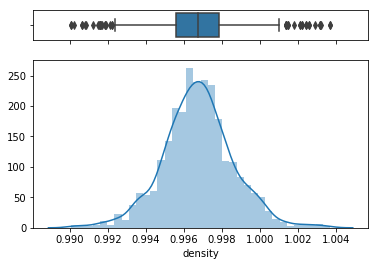

_________________________________________

______	 pH 	_________
Total Values = 	 1599 

3.30    57
3.36    56
3.26    53
3.38    48
3.39    48
3.29    46
3.32    45
3.34    43
3.28    42
3.35    39
3.20    39
3.22    39
3.31    39
3.40    37
3.37    37
3.33    37
3.21    36
3.16    36
3.27    35
3.15    34
3.41    34
3.42    33
3.23    32
3.18    30
3.44    29
3.24    29
3.17    27
3.25    26
3.19    25
3.46    22
        ..
3.03     6
3.00     6
3.68     5
3.01     5
2.98     5
2.94     4
2.92     4
3.62     4
3.69     4
3.66     4
3.71     4
2.89     4
3.72     3
3.67     3
3.63     3
2.93     3
4.01     2
2.99     2
3.78     2
2.88     2
3.90     2
3.85     1
3.75     1
2.74     1
2.86     1
2.95     1
3.74     1
2.87     1
2.90     1
3.70     1
Name: pH, Length: 89, dtype: int64
Number of Unique Values are  89
IQR Outliners = 	 (array([  45,   94,   95,  151,  268,  276,  440,  544,  553,  554,  555,
        557,  588,  614,  650,  656,  657,  695,  821,  930,  934,  996,
        

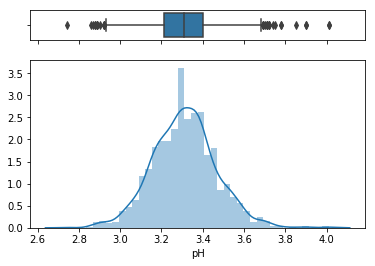

_________________________________________

______	 sulphates 	_________
Total Values = 	 1599 

0.60    69
0.58    68
0.54    68
0.62    61
0.56    60
0.57    55
0.59    51
0.53    51
0.55    50
0.63    48
0.52    47
0.64    46
0.61    45
0.66    42
0.65    41
0.67    36
0.68    35
0.70    33
0.49    31
0.48    29
0.72    28
0.50    27
0.73    26
0.51    26
0.74    26
0.71    26
0.77    26
0.76    25
0.69    23
0.78    23
        ..
1.95     2
0.95     2
1.28     2
1.13     2
1.07     2
0.98     2
1.10     2
1.14     2
1.04     2
1.03     2
1.33     1
2.00     1
1.34     1
1.00     1
1.09     1
1.59     1
1.01     1
1.22     1
1.12     1
1.15     1
1.98     1
1.62     1
1.31     1
1.56     1
1.16     1
1.20     1
0.33     1
1.26     1
1.11     1
1.61     1
Name: sulphates, Length: 96, dtype: int64
Number of Unique Values are  96
IQR Outliners = 	 (array([  13,   17,   19,   43,   79,   81,   83,   86,   88,   91,   92,
        106,  151,  161,  169,  181,  201,  226,  240,  258,  281, 

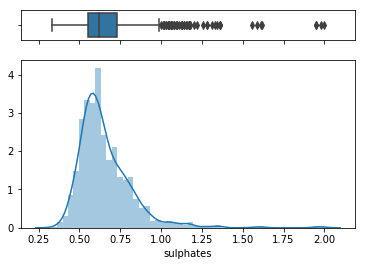

_________________________________________

______	 alcohol 	_________
Total Values = 	 1599 

9.500000     139
9.400000     103
9.800000      78
9.200000      72
10.000000     67
10.500000     67
9.300000      59
11.000000     59
9.600000      59
9.700000      54
9.900000      49
10.900000     49
10.100000     47
10.200000     46
10.800000     42
10.400000     41
11.200000     36
10.300000     33
11.300000     32
11.400000     32
11.500000     30
9.000000      30
11.800000     29
10.600000     28
10.700000     27
11.100000     27
11.700000     23
9.100000      23
12.500000     21
12.000000     21
            ... 
12.300000     12
12.200000     12
12.900000      9
12.700000      9
14.000000      7
13.000000      6
12.600000      6
13.600000      4
13.400000      3
13.300000      3
8.400000       2
9.550000       2
8.800000       2
8.700000       2
13.100000      2
10.550000      2
10.033333      2
10.750000      1
9.250000       1
8.500000       1
13.500000      1
9.233333       1
11.95

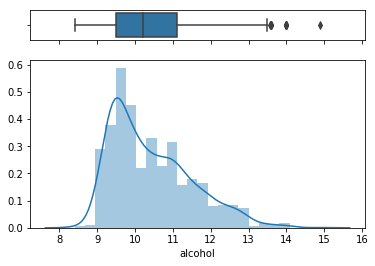

_________________________________________

______	 quality 	_________
Total Values = 	 1599 

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64
Number of Unique Values are  6
IQR Outliners = 	 (array([ 267,  278,  390,  440,  455,  459,  481,  495,  498,  517,  588,
        690,  828,  832,  899, 1061, 1090, 1120, 1202, 1269, 1299, 1374,
       1403, 1449, 1469, 1478, 1505, 1549], dtype=int64),) 

_________________________________________


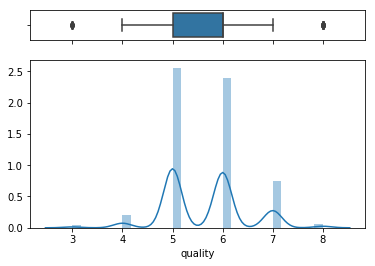

_________________________________________


In [29]:
display_field_info(numerical_cat)

In [30]:
# target attribute
target_attribute_name = 'quality'
target = et5_df[target_attribute_name]

# predictor attributes
predictors = et5_df.drop(target_attribute_name, axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute is already binary
standard_scaler = preprocessing.StandardScaler()
predictors = standard_scaler.fit_transform(predictors)

Split the data set into a training (80%) and test (20%) data sets.

In [31]:
# pepare independent stratified data sets for training and test of the final model
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, test_size=0.20, shuffle=True, stratify=target, random_state=0)

## B. Feature Selection

#### 1. Apply RFE with SVM for selecting the best features

In [32]:
# create a base classifier used to evaluate a subset of attributes
estimatorSVM = svm.SVR(kernel="linear")
selectorSVM = RFE(estimatorSVM, 3)
selectorSVM = selectorSVM.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorSVM.support_)
print(selectorSVM.ranking_)

[False  True False False False False False False False  True  True]
[3 1 7 5 2 8 6 4 9 1 1]


#### 2. Apply RFE with Logistic Regression for selecting the best features

In [33]:
# create a base classifier used to evaluate a subset of attributes
estimatorLR = LogisticRegression()
# create the RFE model and select 3 attributes
selectorLR = RFE(estimatorLR, 3)
selectorLR = selectorLR.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorLR.support_)
print(selectorLR.ranking_)

[False  True False False False False  True False False False  True]
[5 1 9 7 3 8 1 6 4 2 1]


In [34]:
predictors_train_SVMselected = selectorSVM.transform(predictors_train)
predictors_test_SVMselected = selectorSVM.transform(predictors_test)

In [35]:
predictors_train_LRselected = selectorLR.transform(predictors_train)
predictors_test_LRselected = selectorLR.transform(predictors_test)

### Train and evaluate SVM classifiers with both the selected features and all features 

Here we train three models:
* model1 - with the features selected by SVM
* model2 - with the features selected by Logistic Regression
* model3 - with all features (i.e. without feature selection)

In [36]:
classifier = svm.SVC()

In [37]:
svm_model = classifier.fit(predictors_train_SVMselected, target_train)
svm_model.score(predictors_test_SVMselected, target_test)

0.615625

In [38]:
LR_model = classifier.fit(predictors_train_LRselected, target_train)
LR_model.score(predictors_test_LRselected, target_test)

0.5875

In [39]:
withoutfeature_model = classifier.fit(predictors_train, target_train)
withoutfeature_model.score(predictors_test, target_test)

0.65

 # Task 1 (CS5062)
* Repeat the experiment in Etivity5-Feature Selection.ipynb with winequality_red.csv and draw initial conclusions from the results you observe.
* Download the Jupyter notebook Etivity5-Feature Selection and the data set seeds_dataset_binary.csv from GitLab and look through the notebook.
* Download the data set winequality_red.csv from GitLab. This is one of the public UCI datasets.

The initial predictions scores show that scores without features is higher with a prediction score of .66 in comparision to SVM score of 61.25 and Linear Regression both scoring .61875

# Task 2 (CS5062)
* Repeat the experiment in Etivity5-Feature Selection.ipynb with winequality_red.csv but this time run the whole experiment in a loop with different training/test stratified splits. 
* Evaluate the three models for each iteration of the loop separately and boxplot the accuracies of the models for each iteration. 
* Compare the results of this experiment to the results of Task 1 in a markdown cell (max 150 words).

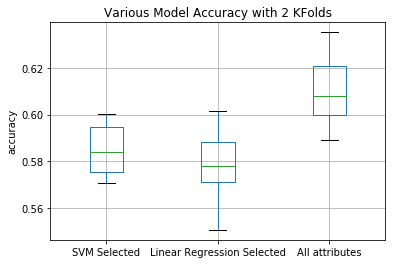

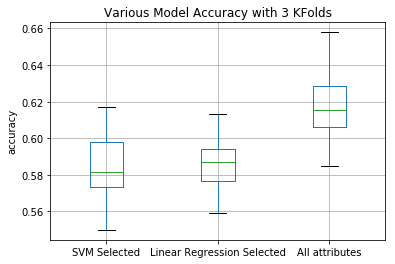

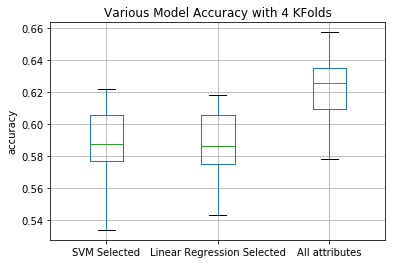

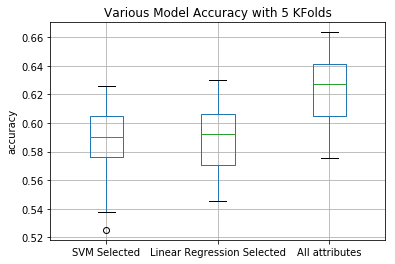

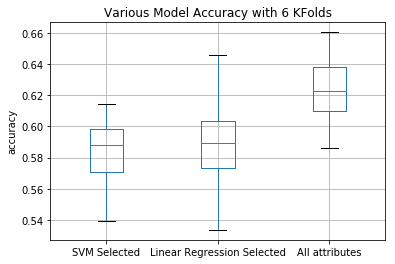

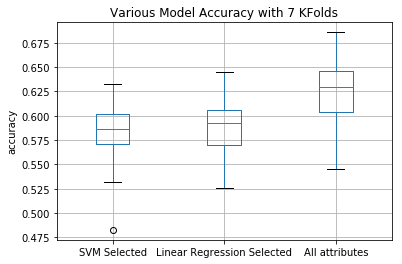

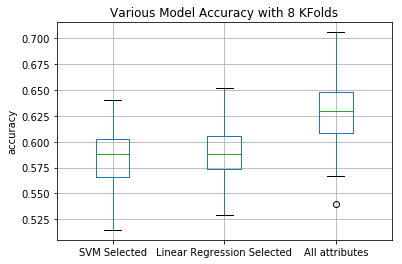

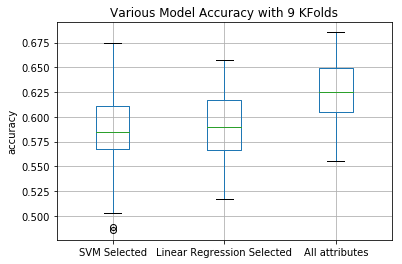

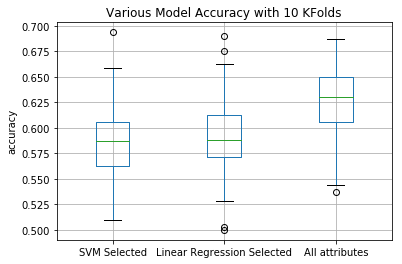

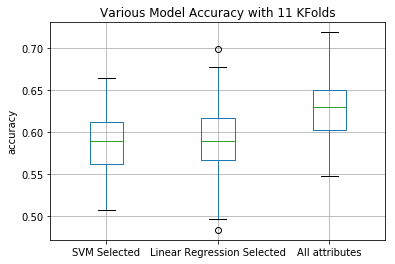

In [40]:
# basing on cormacs approach
for i in range(2,12):
    SVM_scores = []
    LR_scores = []
    allf_scores = []
    for j in range(10):
        skf = StratifiedKFold(n_splits=i, shuffle=True)
        skf.get_n_splits(predictors, target)
        for train_index, test_index in skf.split(predictors, target):
            predictors_train, predictors_test = predictors[train_index], predictors[test_index]
            target_train, target_test = target[train_index], target[test_index]
            predictors_train_SVMselected = selectorSVM.transform(predictors_train)
            predictors_test_SVMselected = selectorSVM.transform(predictors_test)
            predictors_train_LRselected = selectorLR.transform(predictors_train)
            predictors_test_LRselected = selectorLR.transform(predictors_test)
            classifier = svm.SVC()
            model1 = classifier.fit(predictors_train_SVMselected, target_train)
            SVM_scores.append(model1.score(predictors_test_SVMselected, target_test))
            model2 = classifier.fit(predictors_train_LRselected, target_train)
            LR_scores.append(model2.score(predictors_test_LRselected, target_test))
            model3 = classifier.fit(predictors_train, target_train)
            allf_scores.append(model3.score(predictors_test, target_test))
    
    df = pd.DataFrame({
        'SVM Selected': SVM_scores,
        'Linear Regression Selected' : LR_scores,
        'All attributes' : allf_scores
    })
    df.boxplot()
    plt.title("Various Model Accuracy with {} KFolds".format(i))
    plt.ylabel("accuracy")
    plt.show()

# Task 3 (CS5062)
* Build two pipelines for training classifiers for the dataset winequality_red.csv and summarise the results from training classifiers with the pipelines in a markdown cell (max 150 words). 
* The two pipelines should include feature-selection methods, and the feature-selection method in pipeline 1 should be different from the feature-selection method in pipeline 2.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(predictors,target, test_size=0.2, random_state=0)

In [42]:
# Create pipeline one
pipeline_one = Pipeline([
    ('scaler',MinMaxScaler()),
      ('feature_selection', SelectFromModel(LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))),
      ('logistic_regression', LogisticRegression())
])
pipeline_one.fit(X_train,y_train)
# validate pipeline one
kfold = KFold(n_splits=2, random_state=0)
X_train_val = cross_val_score(pipeline_one, X_train,y_train, cv=kfold)
print(X_train_val.mean())

0.5582294111893584


In [43]:
y_predict_one = pipeline_one.predict(X_train)

In [44]:
linear_reg_score_train = pipeline_one.score(X_train, y_train)
print(linear_reg_score_train)

0.5629397967161845


In [45]:
linear_reg_score_test = pipeline_one.score(X_test, y_test)
print(linear_reg_score_train)

0.5629397967161845


In [46]:
# create pipeline two
pipeline_two = Pipeline([
      ('scaler',MinMaxScaler()),
      ('feature_selection', SelectKBest(k=5)),
      ('SVM', svm.SVR(kernel="linear"))
])
model = pipeline_two.fit(X_train,y_train)
# validate pipeline two
kfold = KFold(n_splits=10, random_state=0)
results = cross_val_score(pipeline_two, X_train,y_train, cv=kfold)
print(results.mean())

0.3245444158746508


In [47]:
y_predict_two = pipeline_two.predict(X_train)

In [48]:
random_forest_train = pipeline_two.score(X_train, y_train)
print(linear_reg_score_train)

0.5629397967161845


In [49]:
random_forest_test = pipeline_two.score(X_test, y_test)
print(linear_reg_score_train)

0.5629397967161845
